In [2]:
import gym
import gym_interf
import numpy as np
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
import torch
import torch.nn as nn
from torch.distributions import Normal, Beta, Uniform
from utils import Replay_buffer, action_rescale
from TD3 import TD3
from normal_noise import Normal_noise
from Randomizations import make_env
import os

In [ ]:
import wandb
wandb.init(project="interferobot", group='Lense/TD3/Randomizations')

In [5]:
# env = gym.make('interf-v1')
randomizations=['Radius', 'Brightness', 'ChannelShifter','ActionNoise']
env = make_env('interf-v2', randomizations)

# Define hyperparameters

In [6]:
max_timesteps = 1e6     # max training episodes
episode_timesteps = 50    # max timesteps in one episode
log_interval = episode_timesteps * 20    # print avg reward in the interval
evaluate_interval = log_interval * 10
update_timestep = 10  # Replay buffer size, update policy every n timesteps
replay_size = int(1e5)
start_train = int(1e4)
init_scheme = 'ortog_init'


num_eval_episodes = 50
log_dir= './logs'
try:
    os.makedirs(log_dir)
except:
    pass

# writer = SummaryWriter(log_dir)
writer = wandb
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Agent hyperparameters
agent_hyp = {
    'writer': writer,
     'state_dim': [16,64,64],
     'action_dim': 5,
     'n_latent_var': 512,
     'pi_lr': 1e-5,
     'q_lr': 1e-4,
     'betas': (0.9, 0.999),
     'gamma': 0.8,
     'epochs': 10,
     'batch_size': 32,
     'device': device,
     'polyak': 0.995,
     'max_grad_norm': 10, # max size of optimization step
     'target_noise': 0.2,
     'noise_clip': 0.5,
     'policy_delay': 1,
     'critic_L2_norm': 0,
     'encoder': 'VGG'
    }

decaying_hyp = {
    'eps_max': 0.5,
    'mult': 1 - 3e-6    
}


In [7]:
def reward_func(visib):
    eps = 1e-5
    reward = (visib - np.log(1-visib + eps))
    return reward

In [8]:
class Normalize_obs_and_change_reward(gym.Wrapper):
    """ Sets done flag to true when agent reach > 0.9 visib"""
    def __init__(self, env):
        super().__init__(env)
        env.radius = 0.714
        env.set_max_steps(episode_timesteps)
        env.set_piezo_std(0.5) # It is a phase noise model. It was built right in the environment
        self.evaluate = False
        
    def step(self, action):
        # Check is out of bound act
        mirror_position = np.array([self.mirror1_screw_x, self.mirror1_screw_y,
                                    self.mirror2_screw_x, self.mirror2_screw_y,
                                    self.reduced_lens_dist])
        new_mirror_position = mirror_position + action
        out_bound = any(abs(new_mirror_position) > 1)
        
        obs, rew, done, info = self.env.step(action)
        visib = rew + 1

        rew = reward_func(env.info['visib_device'])
        
        if out_bound and not self.evaluate:
            rew = -2 / episode_timesteps
            done = True

        normalized_obs = obs / 255          
        return normalized_obs, rew, done, info

    def reset(self, evaluate=False, **kwargs):
        obs = self.env.reset(**kwargs)
        self.evaluate = evaluate
        normalized_obs = obs / 255
        return normalized_obs


env = Normalize_obs_and_change_reward(env)

In [10]:
agent = TD3(**agent_hyp)

In [11]:
import types
if writer.__name__ == 'wandb':
    logs_hyp = agent_hyp.copy()
    del logs_hyp['device']
    del logs_hyp['writer']
    logs_hyp['max_timesteps'] = max_timesteps    # max training episodes
    logs_hyp['episode_timesteps'] = episode_timesteps    # max timesteps in one episode
    logs_hyp['update_timestep'] = update_timestep   # Replay buffer size, update policy every n timesteps
    logs_hyp['replay_size'] = replay_size
    logs_hyp['start_train'] = start_train
    logs_hyp['init_scheme'] = init_scheme
    logs_hyp['randomizations'] = randomizations
    logs_hyp.update(decaying_hyp)
    if type(logs_hyp['target_noise']) == type(lambda: x):
        logs_hyp['target_noise'] = logs_hyp['target_noise'].__name__
        logs_hyp.update(decaying_td_noise)
    
    writer.config.update(logs_hyp)
    
    def add_scalar(self, name, value, timestep):
        return self.log({name: value}, timestep)

    def add_histogram(self, name, value, timestep):
        return self.log({name: wandb.Histogram(value.detach().cpu().numpy())}, timestep)
    def add_figure(self, name, fig, timestep):
        return self.log({name: wandb.Image(fig)}, timestep)

    writer.add_scalar = types.MethodType(add_scalar, writer)
    writer.add_histogram = types.MethodType(add_histogram, writer)
    writer.add_figure = types.MethodType(add_figure, writer)
    writer.watch(agent.policy_old)

In [14]:
from tqdm.notebook import trange
from IPython.display import clear_output

In [15]:
def evaluate(agent, timestep):
    agent.eval()
    average_episode_reward = np.zeros((num_eval_episodes, episode_timesteps))
    all_visib = np.zeros((num_eval_episodes, episode_timesteps))
    episode_mirror1 = []
    episode_mirror2 = []
    episode_angle_between_beams = []
    all_out_bound = []
    for episode in range(num_eval_episodes):
        obs = env.reset(evaluate=True)
        episode_mirror1.append([env.mirror1_screw_x, env.mirror1_screw_y])
        episode_mirror2.append([env.mirror2_screw_x, env.mirror2_screw_y])
        done = False
        episode_reward = []
        episode_visib = []
        j = -1
        while not done:
            j += 1
            with torch.no_grad():
                mu = agent(np.array([obs]))
                action = mu.detach().cpu().numpy()[0]
                res_act = action_rescale(action)
            
            obs, reward, done, info = env.step(res_act)
            average_episode_reward[episode, j] += reward
            all_visib[episode, j] += info['visib_device']

    writer.add_scalar('eval/episode_reward',
                      np.array(average_episode_reward).sum(axis=1).mean(),
                      timestep
    )
    writer.add_scalar('eval/Mean visib',
                          np.array(all_visib).mean(),
                          timestep
    )
    writer.add_scalar('eval/median_episode_reward',
                      np.median(np.array(average_episode_reward).sum(axis=1)),
                      timestep
    )
    writer.add_scalar('eval/min_episode_reward',
                      np.min(np.array(average_episode_reward).sum(axis=1)),
                      timestep
    )
    
    fig = plt.figure()
    all_visib = np.array(all_visib)
    all_std = np.sqrt(((all_visib - all_visib.mean(axis=0)) ** 2).mean(0))
    upper_bound = (np.array(all_visib).mean(axis=0) + all_std)
    lower_bound = np.clip((np.array(all_visib).mean(axis=0) - all_std), a_min=0, a_max=None)
    plt.plot(all_visib.mean(axis=0))
    plt.fill_between(np.arange(all_visib.shape[1]), upper_bound, lower_bound, facecolor='blue', alpha=0.2)
    plt.minorticks_on()


    plt.grid(which='major',
            color = 'k', 
            linewidth = 1)

    plt.grid(which='minor', 
            color = 'k', 
            linestyle = ':')
    plt.ylim(0,1)  
  
    writer.add_figure('eval/Visib_distrib', fig, timestep)
    return np.array(average_episode_reward).sum(axis=1).mean()

In [16]:
memory = Replay_buffer(replay_size, agent_hyp['state_dim'], agent_hyp['action_dim'])

warm_up_step = 0
while warm_up_step < start_train:
    state = env.reset()
    while True:
        action = np.random.uniform(-1, 1, agent_hyp['action_dim'])
        resc_act = action_rescale(action)
        next_state, rewards, dones, info = env.step(resc_act)
        
        memory.add(state, action, rewards, dones)
        state = next_state
        
        warm_up_step += 1
        if dones:
            break

Timestep 34003 	 episode reward: 0.7516315028328091 	


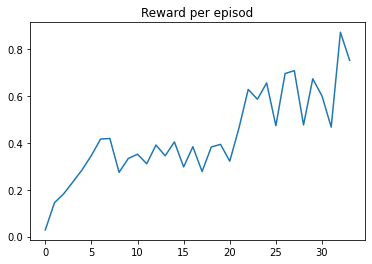

In [ ]:
print(device)

best_reward = 0
epoch_reward_history = []

timestep = 0
noise = Normal_noise(agent_hyp['action_dim'], scale=exp_decay_eps(timestep))
eval_triger = 0
log_triger = 0

# training loop
episode_rewards = []
episode_visib = []
episode_max_visib = []
episode_angle_between_beams = []
episode_step = 0
state = env.reset()
while timestep < max_timesteps:
    episode_rewards.append(0)
    episode_max_visib.append(0)
    episode_angle_between_beams = []
    noise.reset()
    eps = exp_decay_eps(timestep)
    noise.scale = eps
    state = env.reset()
    while True:
        timestep += 1
        episode_step += 1

        with torch.no_grad():
            action = agent.select_action(np.array([state]), noise)
            resc_act = action_rescale(action)
        
        next_state, rewards, dones, info = env.step(resc_act)
                  
        
        # Saving reward and is_terminal:
        memory.add(state, action, rewards, dones)
        state = next_state
        
        # update if its time
        if timestep % update_timestep == 0:
            agent.update(memory, timestep, False)

        episode_rewards[-1] += rewards 
        episode_visib.append(info['visib_device'])
        episode_max_visib[-1] = env.info['visib_device'] if env.info['visib_device'] > episode_max_visib[-1] else episode_max_visib[-1]
        episode_angle_between_beams.append(info['angle_between_beams'])
        
        if dones:
            break
    
    # Evaluating
    if timestep // evaluate_interval > eval_triger:
        eval_triger += 1
        eval_reward = evaluate(agent.policy_old, timestep)

        if eval_reward > best_reward:
            best_reward = eval_reward
            torch.save({
                'actor': agent.policy_old.state_dict(),
                'explorer': agent.policy.state_dict(),
                'Q1': agent.critic1.state_dict(),
                'Q2': agent.critic2.state_dict(),
                'tg_Q1': agent.target_critic1.state_dict(),
                'tg_Q2': agent.target_critic2.state_dict(),
            }, log_dir+'/agent{:.3f}.pt'.format(eval_reward))
            if writer.__name__ == 'wandb':
                wandb.save(log_dir+'/agent{:.3f}.pt'.format(eval_reward))


    # logging
    if timestep // log_interval > log_triger:
        log_triger += 1
        writer.add_scalar('Hyperparameters/Eps',
                          eps,
                          timestep
        )
        writer.add_scalar('Effectiveness/Mean_reward_per_trajectory',
                          np.mean(episode_rewards),
                          timestep
        )
        writer.add_scalar('Effectiveness/Median_reward_per_trajectory',
                          np.median(episode_rewards),
                          timestep
        )
        writer.add_scalar('Effectiveness/Max_reward_per_trajectory',
                          np.max(episode_rewards),
                          timestep
        )
        writer.add_scalar('Effectiveness/Min_reward_per_trajectory',
                          np.min(episode_rewards),
                          timestep
        )
        writer.add_scalar('Effectiveness/Mean_episode_length',
                          episode_step / len(episode_rewards),
                          timestep
        )
        writer.add_scalar('Effectiveness/Mean visib',
                          np.array(episode_visib).mean(),
                          timestep
        )
        writer.add_scalar('Effectiveness/Angle between beams',
                          np.array(episode_angle_between_beams).mean(),
                          timestep
        )
        writer.add_scalar('Effectiveness/Max visib',
                          np.array(episode_max_visib).mean(),
                          timestep
        )
        clear_output(True)
        print('Timestep {} \t episode reward: {} \t'.format(timestep, np.mean(episode_rewards)))
        epoch_reward_history.append(np.mean(episode_rewards))
        plt.title("Reward per episod")
        plt.plot(epoch_reward_history)
        plt.show()  
        
        episode_rewards = []
        episode_step = 0
        episode_visib = []
        episode_max_visib = []
        episode_angle_between_beams = []